In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/A Machine Learning Based Approach to Classify Tense from English Text/Dataset/TenseUniqueDataset.xlsx')

In [ ]:
df.columns

Index(['Labels', 'Sentence'], dtype='object')

Unique labels in the dataset: [1 2 3]
Transformed unique labels: [0 1 2]
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


306/306 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.7797 - loss: 0.4428 - val_accuracy: 0.9895 - val_loss: 0.0386
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9956 - loss: 0.0165 - val_accuracy: 0.9930 - val_loss: 0.0271
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9880 - val_loss: 0.0375
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9870 - val_loss: 0.0439
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9990 - loss: 0.0025 - val_accuracy: 0.9885 - val_loss: 0.0533
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 1.3946e-04 - val_accuracy: 0.9895 - val_loss: 0.0535
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 1.0000 - loss: 6.9299e-05 - val_accuracy: 0.9890 - val_loss: 0.0585
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 1.660

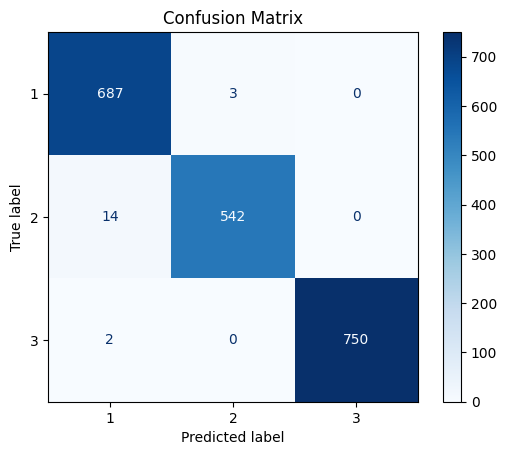

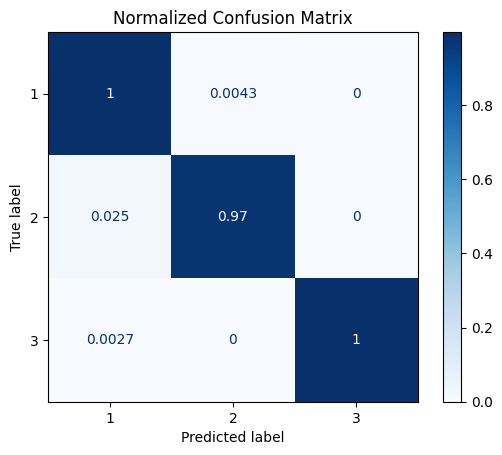

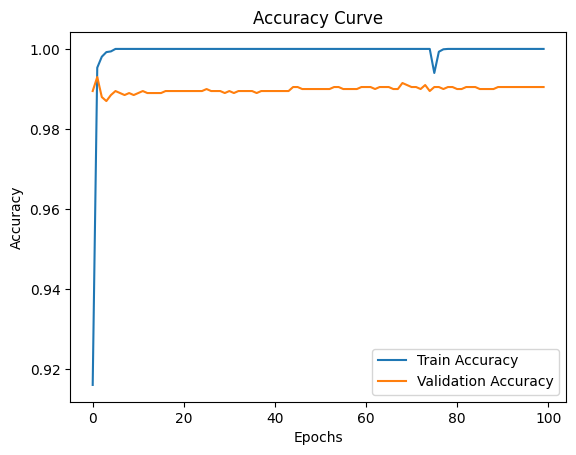

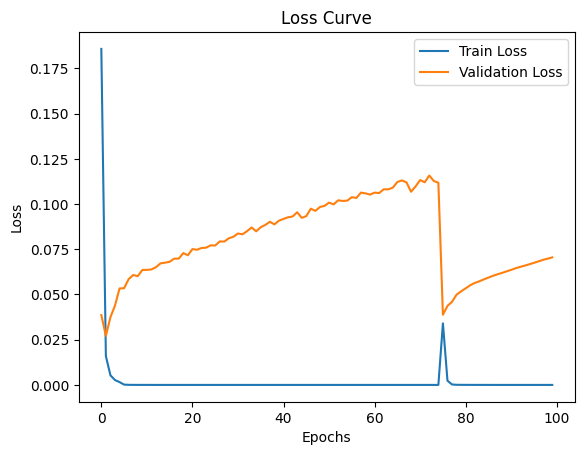

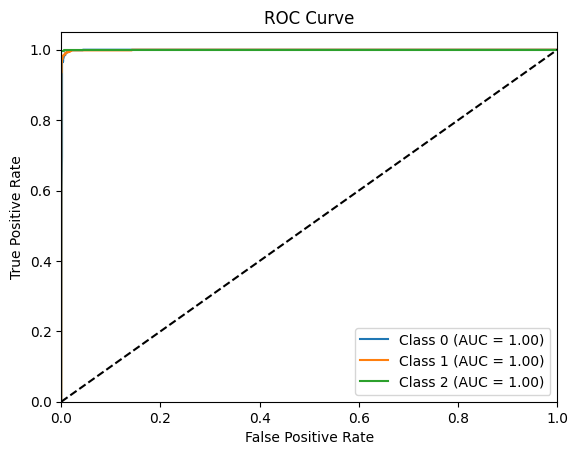

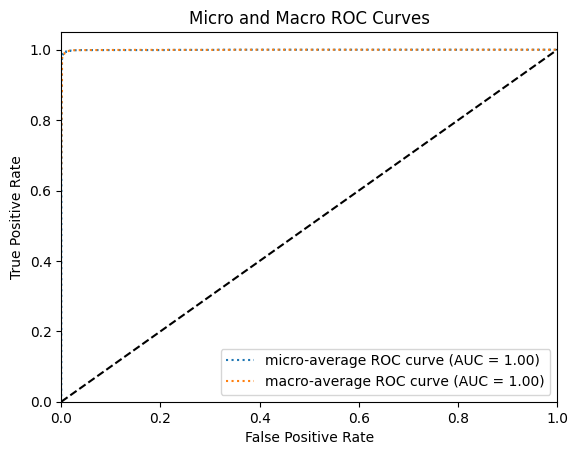

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Load your dataset
#df = pd.read_excel('/content/drive/MyDrive/A Machine Learning Based Approach to Classify Tense from English Text/Dataset/TenseUniqueDataset.xlsx')

# Assuming the dataset has 'Sentence' and 'Tense' columns
sentences = df['Sentence'].values
labels = df['Labels'].values

# Check unique values in labels
unique_labels = np.unique(labels)
print(f"Unique labels in the dataset: {unique_labels}")

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Check the transformed labels
transformed_unique_labels = np.unique(labels)
print(f"Transformed unique labels: {transformed_unique_labels}")

# Ensure num_classes matches the number of unique labels
num_classes = len(transformed_unique_labels)
labels = to_categorical(labels, num_classes=num_classes)

# Tokenize the sentences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
sentence_lengths = [len(seq) for seq in sequences]

# Pad the sequences
max_sequence_length = int(np.percentile(sentence_lengths, 95))
data = pad_sequences(sequences, maxlen=max_sequence_length)

embedding_dim = 200
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.15, random_state=42)

# Build the Bi-LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=37, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# General and Normalized Confusion Matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

cm_normalized = confusion_matrix(y_true, y_pred_classes, normalize='true')
cm_normalized_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_encoder.classes_)
cm_normalized_display.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()

# Accuracy and Loss Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC and AUC Curves
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Calculate macro and micro average ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', linestyle=':')
plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', linestyle=':')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Micro and Macro ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()